<a href="https://colab.research.google.com/github/rmontenegroo/discursos/blob/main/nlp_discursos_camara_w2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulos

In [ ]:
!pip install --upgrade gensim==4.1.2

In [ ]:
import os
import base64
import zlib
import gensim
import glob
import nltk
import re
import wordcloud
import string

nltk.download('punkt')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Parâmetros

In [ ]:
ROOTDIR = '/content/drive/MyDrive/Pós/discursos/'
SEED = 12

# Carregar dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
discursos = pd.DataFrame()

if not os.path.isfile(ROOTDIR + 'data/sentences_discursos.json'):

  discursos = pd.DataFrame()

  for arquivo in glob.glob(ROOTDIR + 'data/discursos_*.json'):

    discursos = pd.concat(
              ( discursos, pd.read_json(arquivo) )
    )

  discursos = discursos.reset_index(drop=True)
  discursos['original'] = discursos.discurso_zipped_b64.map(lambda i: zlib.decompress(base64.b64decode(i)).decode())
  discursos = discursos.drop(columns=['discurso_zipped_b64'])

else:
  discursos = pd.read_json(ROOTDIR + 'data/sentences_discursos.json')

In [ ]:
discursos

,idDeputado,idLegislatura,original
0,62881,56,O SR. DANILO FORTE (PSDB - CE. Pela ordem. Sem...
1,62881,56,O SR. DANILO FORTE (PSDB - CE. Sem revisão do ...
2,62881,56,O SR. DANILO FORTE (PSDB - CE. Pela ordem. Sem...
3,62881,56,O SR. DANILO FORTE (PSDB - CE. Pela ordem. Sem...
4,62881,56,O SR. DANILO FORTE (PSDB - CE. Como Líder. Sem...
...,...,...,...
189915,204760,55,O SR. WASHINGTON CORAÇÃO VALENTE (PDT - RS. Pe...
189916,205234,55,O SR. FELIPE SOUZA (PODE - AM. Pela ordem. Sem...
189917,205234,55,O SR. FELIPE SOUZA (PODE - AM. Pela ordem. Sem...
189918,205234,55,O SR. FELIPE SOUZA (PTN - AM. Sem revisão do o...


# Preparar os dados para o embedding

## Extraindo as sentenças para criar o embedding

In [ ]:
def texto2Sentences(texto):

  texto = texto.strip().lower()

  texto = texto.replace('sra.','sra').replace('sras.', 'sras').replace('sr.', 'sr').replace('srs.', 'srs')

  if 'sem revisão do orador.)' in texto.split('\n')[0]:
    texto = texto.split('sem revisão do orador.)')[1].strip()

  if 'pronuncia o seguinte discurso.)' in texto.split('\n')[0]:
    texto = texto.split('pronuncia o seguinte discurso.)')[1].strip()

  if texto.startswith('- sr presidente,'):
    texto = texto.replace('- sr presidente,', '').strip()

  return sent_tokenize(texto)

In [ ]:
if not 'sentences' in discursos.columns:
  discursos['sentences_'] = discursos.original.map(lambda d: texto2Sentences(d))

## Tokenizando as sentenças

In [ ]:
def limpaSentence(texto):
  texto = texto.translate(str.maketrans(string.punctuation + '–', ' '*(len(string.punctuation)+1)))
  texto = texto.translate(str.maketrans(string.digits, ' '*len(string.digits)))
  texto = ' '.join(texto.split())
  return texto.strip()

In [ ]:
if not 'sentences' in discursos.columns:
  discursos['sentences'] = discursos.sentences_.map(lambda ss: [word_tokenize(limpaSentence(s)) for s in ss])
  discursos.drop(columns=['sentences_'], inplace=True)
  discursos.to_json(ROOTDIR + 'data/sentences_discursos.json')

In [ ]:
discursos.iloc[1].sentences[0]

['sras',
 'e',
 'srs',
 'deputados',
 'primeiro',
 'parabenizo',
 'o',
 'plenário',
 'desta',
 'casa',
 'pela',
 'atitude',
 'madura',
 'conveniente',
 'para',
 'este',
 'momento',
 'tão',
 'difícil',
 'por',
 'que',
 'passa',
 'o',
 'brasil',
 'inteiro',
 'a',
 'decisão',
 'do',
 'adiamento',
 'das',
 'eleições',
 'do',
 'ano',
 'de',
 'essa',
 'decisão',
 'nos',
 'dá',
 'segurança',
 'do',
 'ponto',
 'de',
 'vista',
 'sanitário',
 'e',
 'nos',
 'dá',
 'a',
 'garantia',
 'de',
 'que',
 'estamos',
 'entendendo',
 'a',
 'mutação',
 'do',
 'vírus',
 'o',
 'avanço',
 'e',
 'a',
 'dinâmica',
 'dele',
 'uma',
 'dinâmica',
 'perversa']

In [ ]:
discursos

,idDeputado,idLegislatura,original,sentences
0,62881,56,O SR. DANILO FORTE (PSDB - CE. Pela ordem. Sem...,"[[caros, colegas, e, amigos, alguns, saudosos,..."
1,62881,56,O SR. DANILO FORTE (PSDB - CE. Sem revisão do ...,"[[sras, e, srs, deputados, primeiro, parabeniz..."
2,62881,56,O SR. DANILO FORTE (PSDB - CE. Pela ordem. Sem...,"[[obrigado, sr, presidente, marcos, pereira], ..."
3,62881,56,O SR. DANILO FORTE (PSDB - CE. Pela ordem. Sem...,"[[presidente, vou, dar, continuidade, à, minha..."
4,62881,56,O SR. DANILO FORTE (PSDB - CE. Como Líder. Sem...,"[[sras, e, srs, deputados, o, tema, que, me, t..."
...,...,...,...,...
189915,204760,55,O SR. WASHINGTON CORAÇÃO VALENTE (PDT - RS. Pe...,"[[hoje, nesta, casa, protocolei, dois, projeto..."
189916,205234,55,O SR. FELIPE SOUZA (PODE - AM. Pela ordem. Sem...,"[[tomei, posse, ontem], [sou, deputado, federa..."
189917,205234,55,O SR. FELIPE SOUZA (PODE - AM. Pela ordem. Sem...,"[[o, bom, senso, de, não, se, estourar, o, orç..."
189918,205234,55,O SR. FELIPE SOUZA (PTN - AM. Sem revisão do o...,"[[eu, felipe, souza, deputado, federal, pelo, ..."


## Determinando o tamanho do corpus e frequência das palavras

In [ ]:
palavras_indesejadas = ['gggggoverno']

In [ ]:
counter = Counter()
for discurso in discursos.sentences.values:
  for doc in discurso:
    counter.update(doc)

for pi in palavras_indesejadas:
  del counter[pi]

### Plota as palavras "mais" frequentes

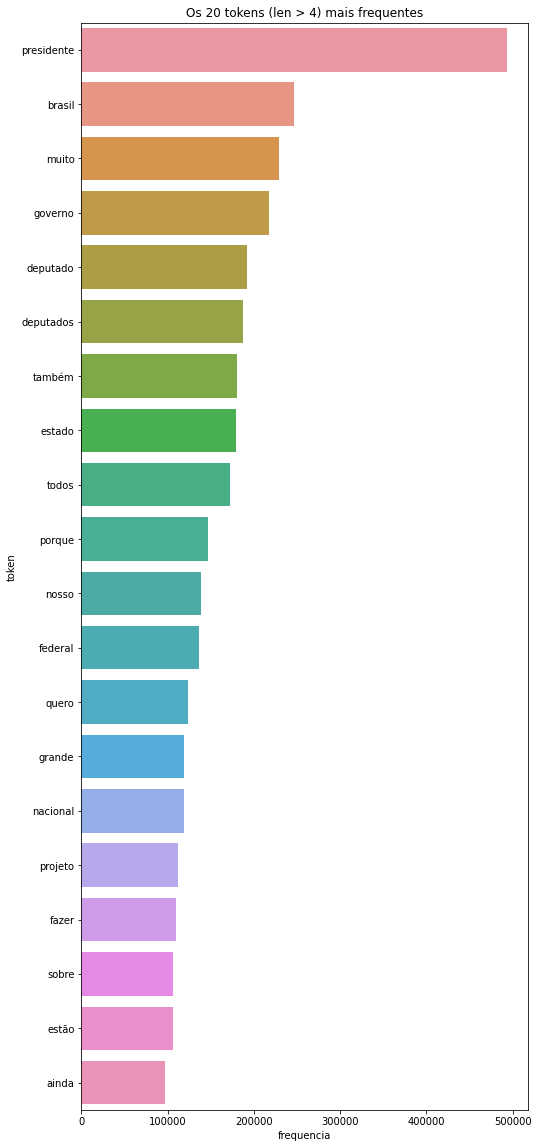

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(8,20))
axes.set_title('Os 20 tokens (len > 4) mais frequentes')
sns.barplot(
              ax=axes, x='frequencia', y='token',
              data=pd.DataFrame(
                  [(tk, fr) for tk, fr in counter.most_common(100) if len(tk) > 4][:20], 
                  columns=['token','frequencia']
              ).sort_values(by='frequencia', ascending=False)
);

In [ ]:
word_count = len(list(counter))
word_count

200103

# Treinando os modelos

## vetor de 50

In [ ]:
vector_size = 50

if not os.path.isfile(ROOTDIR + f'data/camares.{vector_size}.w2v'):
  
  minimo_ocorrencias = 10
  window_size = 5
  epocas=50

  model = Word2Vec(vector_size=vector_size, window=window_size, min_count=minimo_ocorrencias, seed=SEED)

  model.build_vocab_from_freq(word_freq=dict(counter.items()))

  doc_count = discursos.shape[0]
    
  pace = 500
  for i in range(0, doc_count, pace):
    if i % 5000 == 0:
      print(i, ' de ', doc_count, f' {(100*i/doc_count):.2f}%')
    model.train(np.sum(discursos.iloc[i:i+pace].sentences.values), total_words=len(model.wv.key_to_index), epochs=epocas)

  model.save(ROOTDIR + f'data/camares.{vector_size}.w2v')

## vetor de 100

In [ ]:
vector_size = 100

if not os.path.isfile(ROOTDIR + f'data/camares.{vector_size}.w2v'):

  minimo_ocorrencias = 10
  window_size = 5
  epocas=100

  model = Word2Vec(vector_size=vector_size, window=window_size, min_count=minimo_ocorrencias, seed=SEED)

  model.build_vocab_from_freq(word_freq=dict(counter.items()))

  doc_count = discursos.shape[0]
    
  pace = 500
  for i in range(0, doc_count, pace):
    if i % 5000 == 0:
      print(i, ' de ', doc_count, f' {(100*i/doc_count):.2f}%')
    model.train(np.sum(discursos.iloc[i:i+pace].sentences.values), total_words=len(model.wv.key_to_index), epochs=epocas)

  """
  for i, doc in enumerate(discursos.iloc[0:].sentences):
    if i % 5000 == 0:
      print(i, 'de', doc_count, f' {(100*i/doc_count):.2f}%')
    print(doc)
    model.train(doc, total_words=len(model.wv.key_to_index), epochs=epocas)
  """

  model.save(ROOTDIR + f'data/camares.{vector_size}.w2v')

## Vetor de 300

In [ ]:
vector_size = 300

if not os.path.isfile(ROOTDIR + f'data/camares.{vector_size}.w2v'):

  minimo_ocorrencias = 10
  window_size = 5
  epocas=150

  model = Word2Vec(vector_size=vector_size, window=window_size, min_count=minimo_ocorrencias, seed=SEED)

  model.build_vocab_from_freq(word_freq=dict(counter.items()))

  doc_count = discursos.shape[0]
    
  pace = 500
  for i in range(0, doc_count, pace):
    if i % 5000 == 0:
      print(i, ' de ', doc_count, f' {(100*i/doc_count):.2f}%')
    model.train(np.sum(discursos.iloc[i:i+pace].sentences.values), total_words=len(model.wv.key_to_index), epochs=epocas)

  """
  for i, doc in enumerate(discursos.iloc[0:].sentences):
    if i % 5000 == 0:
      print(i, 'de', doc_count, f' {(100*i/doc_count):.2f}%')
    model.train(doc, total_words=len(model.wv.key_to_index), epochs=epocas)
  """

  model.save(ROOTDIR + f'data/camares.{vector_size}.w2v')